# ECE-6524 / CS-6524 Deep Learning
# Assignment 2

In this assignment, **you need to complete the following three sectoins**:
1. PyTorch Basics
    - Toy example with PyTorch
2. Image Classification with PyTorch
    - Implement a simple MLP network for image classification
    - Implement a convolutional network for image classification
    - Experiment with different numbers of layers and optimizers
    - Push the performance of your CNN

This assignment is inspired and adopted from the official PyTorch tutorial.
## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are displayed correctly there. 
7. Zip the all the files along with this notebook (Please don't include the data)
8. Name your PDF file as Assignment2_[YOUR ID NUMBER].
9. Submit your zipped file and the PDF **INDEPENDENTLY**.

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here: 
906161549
### Reference (if any):

In this homework, you would need to use **Python 3.6+** along with the following packages:
```
1. pytorch 1.2
2. torchvision
3. numpy
4. matplotlib
```
To install pytorch, please follow the instructions on the [Official website](https://pytorch.org/). In addition, the [official document](https://pytorch.org/docs/stable/) could be very helpful when you want to find certain functionalities. 



# Section 1. PyTorch Basics [30 pts]

Simply put, PyTorch is a **Tensor** library like Numpy. These two libraries similarly provide useful and efficient APIs for you to deal with your tensor data. What really differentiate PyTorch from Numpy are the following two features:
1. Numerical operations that can **run on GPUs** (more than 10x speedup)
2. Automatic differentiation for building and training neural networks

In this section, we will walk through some simple example, and see how the automatic differentiation functionality can make your life much easier.

## 1.1. Automatic Differentiation
Gradient descent is the driving force of the deep learning field. In the lectures and assignment 1, we learned how to derive the gradient for a given function, and implement methods for calculating and performing gradient descents. We also see how we can manually implement the backward and forward functions for the simple NN example. While implementing these functions may not be a big deal for a small network, it may get very nasty when we want to build something with tens of hundreds of layers.

In PyTorch (as well as other major deep learning libraries), we can use autograd ([automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)) to handle the tedious computation of backward passes. When doing forward passes with autograd, we are essentially defining a **computational graph**, while the nodes in the graph are **tensors**, the edges are the functions that produce output tensors (e.g. ReLU, Linear, Convolutional Layer) given the input tensors. To do backpropagation, we can simply backtrack through this graph to compute gradients. 

This may sound a little bit abstract, so let's take a look at the example:

In [16]:
import torch # import pytorch.

target = 10.

# create a matrix of size 2x2. Each with value draws from standard normal distribution.
x = torch.randn(2, 2, requires_grad=True) 
y = torch.randn(2, 2, requires_grad=True)

a = x + y
b = a.sum()
loss = b - target

# print out each tensor:
print(x)
print(y)
print(a)
print(b)
print(loss)

print("-----gradient-----")
print(x.grad)
print(y.grad)

tensor([[ 1.3366, -0.2947],
        [-0.8357, -0.3957]], requires_grad=True)
tensor([[-0.2059, -0.1954],
        [ 0.3798,  1.9009]], requires_grad=True)
tensor([[ 1.1307, -0.4901],
        [-0.4559,  1.5052]], grad_fn=<AddBackward0>)
tensor(1.6899, grad_fn=<SumBackward0>)
tensor(-8.3101, grad_fn=<SubBackward0>)
-----gradient-----
None
None


In the above example, we have seen a few things:
1. `requires_grad` flag: If false, we can safely exclude this tensor (and its subgraph) from gradient computation and therefore increase efficiency.
2. `grad_fn`: we can see that once an operation is done to a tensor, the output tensor is bound to a backward function associated to the operation. In this case, we have Add, Sum, and Sub.

However, even if we set `requires_grad=True`, we still don't have gradient for `x` and `y`. This is because that we haven't performed the backpropagation yet. So let's do it:

In [17]:
# perform backpropagation from this "node"
loss.backward()
print('-----gradient-----')
print(x.grad)
print(y.grad)

-----gradient-----
tensor([[1., 1.],
        [1., 1.]])
tensor([[1., 1.],
        [1., 1.]])


Great, seems like we can perform gradient descent without writing backwards function! Now, let's see a simple toy example on how we can fit some weights `w1` and `w2` with random input `x` and target `y`: 

In [18]:
dtype = torch.float
#device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.  (because we don't need the gradient for the operation 
    # learning_rate * w1.grad)
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

iteration 99: 602.2464599609375
iteration 199: 2.841336250305176
iteration 299: 0.020719129592180252
iteration 399: 0.0003956901782657951
iteration 499: 5.4059251851867884e-05


## 1.2. `nn` Module
Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.

In PyTorch, the nn package serves this purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

Now, let's see how our simple NN could be implemented using the nn module.

In [19]:
import torch.nn as nn
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

iteration 99: 2.295413017272949
iteration 199: 0.04235706478357315
iteration 299: 0.0015720350202172995
iteration 399: 7.805681525496766e-05
iteration 499: 4.486465513764415e-06


So far, we have been updating the model parameters manually with `torch.no_grad()`. However, if we want to use optimization algorithms other than SGD, it might get a bit nasty to do it manually. Instead of manually doing this, we can use `optim` pacakge to help optimize our model: 

In [20]:
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. 
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

iteration 99: 1.973178744316101
iteration 199: 0.02639385312795639
iteration 299: 0.000612303614616394
iteration 399: 1.777492434484884e-05
iteration 499: 5.776807938673301e-07


Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing nn.Module and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

For example, we can implement our 2-layer simple NN as the following:

In [21]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

iteration 99: 2.658125400543213
iteration 199: 0.05768189579248428
iteration 299: 0.0021922183223068714
iteration 399: 0.00010241292329737917
iteration 499: 5.393704668676946e-06


## 1.3. Warm-up: Two-moon datasets [30 pts]
Now, let's use PyTorch to solve some synthetic datasets. In previous assignment, we have to write some codes to create training batches. Again, this can also be done with PyTorch `DataLoader`. The `DataLoader` utilizes parallel workers to read and prepare batches for you, which can greatly speedup the code when your time bottleneck is on file I/O.

Here, we show a simple example that can create a dataloader from numpy data:

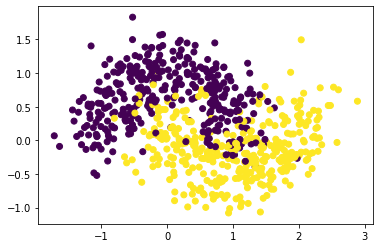

In [22]:
import numpy as np
import matplotlib.pyplot as plt

X_train = np.loadtxt('data/X1_train.csv', delimiter=',')
X_test = np.loadtxt('data/X1_test.csv', delimiter=',')
y_train = np.loadtxt('data/y1_train.csv', delimiter=',')
y_test = np.loadtxt('data/y1_test.csv', delimiter=',')

# Plot it to see why is it called two-moon dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);

Now, let's create a PyTorch `DataLoader`:

In [23]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64 # mini-batch size
num_workers = 4 # how many parallel workers are we gonna use for reading data
shuffle = True # shuffle the dataset

# Convert numpy array import torch tensor
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.reshape(-1, 1))
y_test = torch.LongTensor(y_test.reshape(-1, 1))

# First, create a dataset from torch tensor. A dataset define how to read data
# and process data for creating mini-batches.
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          num_workers=num_workers, shuffle=shuffle)

Below, we provide a simple example on how to train your model with this dataloader:

In [24]:
epoch = 5 # an epoch means looping through all the data in the datasets
lr = 1e-1

# create a simple model that is probably not gonna work well
model = nn.Linear(X_train.size(1), 1)
optim = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epoch):
    loss_epoch = 0
    # loop through train loader to get x and y
    for x, y in train_loader:
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = (y_pred - y.float()).abs().mean()
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')

Epcoh 0: 5.72626006603241
Epcoh 1: 3.136307328939438
Epcoh 2: 2.9289086312055588
Epcoh 3: 2.9055305272340775
Epcoh 4: 2.893790304660797


### 1.3.1 Your Simple NN [30 pts]
Now, it is time for you to implement your own model for this classification task. Your job here is to:
1. Complete the SimpleNN class. It should be a 2- or 3-layer NN with proper non-linearity.
2. Train your model with SGD optimizer.
3. Tune your model a bit so you can achieve at least 80% accuracy on training set.
Hint: you might want to look up `nn.ReLU`, `nn.Sigmoid`, `nn.BCELoss` in the [official document](https://pytorch.org/docs/stable/). You are allowed to freely pick the hyperparameters of your model.

In [25]:
class SimpleNN(nn.Module):
    
    def __init__(self, X_train, y_train):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        inputLayerWidth = X_train.size(1)
        hiddenLayerWidth = X_train.size(1)
        outputLayerWidth = y_train.size(1)
        
        self.linear1 = nn.Linear(inputLayerWidth, hiddenLayerWidth)
        self.linear2 = nn.Linear(hiddenLayerWidth, hiddenLayerWidth)
        self.linear3 = nn.Linear(hiddenLayerWidth, outputLayerWidth)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # feed the input to your network, and output the predictions.                  #
        ################################################################################
    
        # Create ReLU hidden layers, sigmoid output function
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        y_pred = self.sigmoid(self.linear3(x))
        return y_pred
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

Epcoh 0: 8.27334189414978
Epcoh 1: 8.009652972221375
Epcoh 2: 7.808457553386688
Epcoh 3: 7.688997268676758
Epcoh 4: 7.604220151901245
Epcoh 5: 7.532839238643646
Epcoh 6: 7.4714436531066895
Epcoh 7: 7.408111929893494
Epcoh 8: 7.336523234844208
Epcoh 9: 7.25484037399292
Epcoh 10: 7.159810185432434
Epcoh 11: 7.049096763134003
Epcoh 12: 6.931168973445892
Epcoh 13: 6.806959748268127
Epcoh 14: 6.669008255004883
Epcoh 15: 6.5340787172317505
Epcoh 16: 6.398499071598053
Epcoh 17: 6.25496244430542
Epcoh 18: 6.111755728721619
Epcoh 19: 5.977786213159561
Epcoh 20: 5.841543942689896
Epcoh 21: 5.717463463544846
Epcoh 22: 5.590862601995468
Epcoh 23: 5.482297956943512
Epcoh 24: 5.373352468013763
Epcoh 25: 5.267249196767807
Epcoh 26: 5.179555654525757
Epcoh 27: 5.086765766143799
Epcoh 28: 5.00045046210289
Epcoh 29: 4.92561000585556
Epcoh 30: 4.852044641971588
Epcoh 31: 4.785946846008301
Epcoh 32: 4.730055630207062
Epcoh 33: 4.670458257198334
Epcoh 34: 4.63332012295723
Epcoh 35: 4.576793313026428
Epcoh 

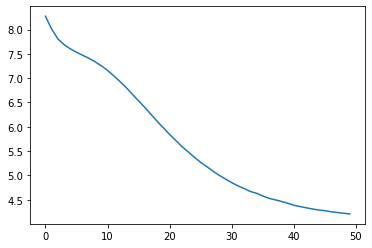

In [26]:
epoch = 50 # an epoch means looping through all the data in the datasets
lr = 1e-2

# create a simple model that is probably not gonna work well

################################################################################
# TODO:                                                                        #
# Initialize your model and SGD optimizer here.                                #
################################################################################
model = SimpleNN(X_train, y_train)
model.to(device)
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
bce_criterion = nn.BCELoss(reduction='mean')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################
loss_hist = []

for e in range(epoch):
    loss_epoch = 0
    ################################################################################
    # TODO:                                                                        #
    # Loop through the dataloader and train your model with nn.BCELoss.            #
    ################################################################################
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = model(x)
        #import pdb; pdb.set_trace()

        #loss = (y_pred - y.float()).pow(2).mean()
        loss = bce_criterion(y_pred, y.float())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        loss_epoch += loss.item()
    loss_hist.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist)
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

In [27]:
# helper function for computing accuracy
def get_acc(pred, y):
    pred = pred.float()
    y = y.float()
    return (y==pred).sum().float()/y.size(0)*100.

Evaluate your accuracy:

In [28]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
y_pred = y_pred.to(device)
y_pred = (model(X_train) > 0.5)
train_acc = get_acc(y_pred, y_train)

y_pred = (model(X_test) > 0.5)
test_acc = get_acc(y_pred, y_test)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

Training accuracy: 84.57142639160156, Testing accuracy: 84.0


# Section 2. Image Classification with CNN [70 pts]
Now, we are back to the image classification problem. In this section, our goal is to, again, train models on CIFAR-10 to perform image classification. Your tasks here are to:
1. Build and Train a simple feed-forward Neural Network (consists of only nn.Linear layer with activation function) for the classification task
2. Build and Train a **Convolutional** Neural Network (CNN) for the classification task
3. Try different settings for training your CNN
4. Reproduce

In the following cell, we provide the code for creating a CIFAR10 dataloader. As you can see, PyTorch's `torchvision` package actually has an interface for the CIFAR10 dataset: 

In [29]:
import torchvision
import torchvision.transforms as transforms

# Preprocessing steps on the training/testing data. You can define your own data augmentation
# here, and PyTorch's API will do the rest for you.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# This will automatically download the dataset for you if it cannot find the data in root
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Addon validation set. We just split the training set into two, where the validation set is 0.2 * trainset
trainset_len = len(trainset)
valset_len = int(0.2*trainset_len)
valset, reduced_trainset = torch.utils.data.random_split(trainset, [valset_len, trainset_len-valset_len])

Files already downloaded and verified
Files already downloaded and verified


## 2.1 Simple NN [30 pts]
Implement a simple feed-forward neural network, and train it on the CIFAR-10 training set. Here's some specific requirements:
1. The network should only consists of `nn.Linear` layers and the activation functions of your choices (e.g. `nn.Tanh`, `nn.ReLU`, `nn.Sigmoid`, etc). 
2. Train your model with `torch.optim.SGD` with the hyperparameters you like the most. 

Note that the hyperparameters work in previous assignment might not work the same, as the implementations of layers could be different.

In [30]:
class SimpleNN(nn.Module):
    
    def __init__(self, feature_size, output_size):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        inputLayerWidth = feature_size
        hiddenLayerWidth = 64
        outputLayerWidth = output_size
        
        self.linear1 = nn.Linear(inputLayerWidth, hiddenLayerWidth)
        self.linear2 = nn.Linear(hiddenLayerWidth, hiddenLayerWidth)
        self.linear3 = nn.Linear(hiddenLayerWidth, outputLayerWidth)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
        # note that: here, the data is of the shape (B, C, H, W)
        # where B is the batch size, C is color channels, and H
        # and W is height and width.
        # To feed it into the linear layer, we need to reshape it
        # with .view() function.
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # reshape the data from (B, C, H, W) to (B, C*H*W)
        ################################################################################
        # TODO:                                                                        #
        # Forward pass, output the prediction score.                                   #
        ################################################################################
        
        # Create ReLU hidden layers, sigmoid output function
        a1 = self.relu(self.linear1(x))
        a2 = self.relu(self.linear2(a1))
        # Note to self: Found out that CE loss function in pytorch already does softmax
        # Also, y labels doesn't need to be manually binarized as it already does it internally
#         y_pred = self.softmax(self.linear3(a2))
#         return y_pred
        return a2
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

Epcoh 0: 1398.71147108078
Epcoh 1: 1195.181910276413
Epcoh 2: 1142.144958615303
Epcoh 3: 1103.1530939340591
Epcoh 4: 1070.7115968465805
Epcoh 5: 1047.8342128396034
Epcoh 6: 1027.2830560803413
Epcoh 7: 1010.3071991205215
Epcoh 8: 994.0303949713707
Epcoh 9: 978.3097742795944
Epcoh 10: 961.9288477897644
Epcoh 11: 954.0750180482864
Epcoh 12: 944.2545765638351
Epcoh 13: 930.5436887741089
Epcoh 14: 920.3894916176796
Epcoh 15: 911.5894015431404
Epcoh 16: 899.6762598752975
Epcoh 17: 890.8600644469261
Epcoh 18: 882.2703922390938
Epcoh 19: 873.5377207994461
Epcoh 20: 864.9878163337708
Epcoh 21: 861.1354857087135
Epcoh 22: 847.7902834415436
Epcoh 23: 844.9993868470192
Epcoh 24: 834.3042683601379
Epcoh 25: 827.622817158699
Epcoh 26: 822.5643528103828
Epcoh 27: 816.3465507626534
Epcoh 28: 805.5643186569214
Epcoh 29: 802.6870357990265


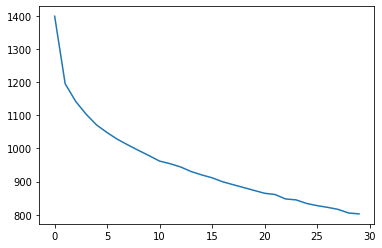

In [31]:
epoch = 30
lr = 1e-2
n_input = 3072
n_classes = 10

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################

model = SimpleNN(n_input, n_classes)
model.to(device)
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

loss_hist = []

for e in range(epoch):
    loss_epoch = 0
    ################################################################################
    # TODO:                                                                        #
    # Loop through the dataloader and train your model with nn.BCELoss.            #
    ################################################################################
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        
        loss = cross_entropy(y_pred, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_epoch += loss.item()
    loss_hist.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################


Now evaluate your model with the helper function:

In [32]:
def get_model_acc(model, loader):
    ys = []
    y_preds = []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        ys.append(y)
        # set the prediction to the one that has highest value
        # Note that the the output size of model(x) is (B, 10)
        y_preds.append(torch.argmax(model(x), dim=1))
    y = torch.cat(ys, dim=0)
    y_pred = torch.cat(y_preds, dim=0)
    print((y == y_pred).sum())
    return get_acc(y_pred, y)

### 2.1.1 Evaluate NN [30 pts]
Evaluate your NN. You should get an accuracy around **50%** on training set and **49%** on testing set.

In [33]:
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(32784, device='cuda:0')
tensor(4711, device='cuda:0')
Training accuracy: 65.56800079345703, Testing accuracy: 47.11000061035156


## 2.2 Convolutional Neural Network (CNN) [40 pts]
Convolutional layer has been proven to be extremely useful for vision-based task. As mentioned in the lecture, this speical layer allows the model to learn filters that capture crucial visual features. 



### 2.2.1 Implement and Evaluate CNN [10 pts]
In this section, you will need to construct a CNN for classifying CIFAR-10 image. Specifically, you need to:
1. build a `CNNClassifier` with `nn.Conv2d`, `nn.Maxpool2d` and activation functions that you think are appropriate. 
2. You would need to flatten the output of your convolutional networks with `view()`, and feed it into a `nn.Linear` layer to predict the class labels of the input. 

Once you are done with your module, train it with `optim.SGD`, and evaluate it. You should get an accuracy around **55%** on training set and **53%** on testing set.

Hint: You might want to look up `nn.Conv2d`, `nn.Maxpool2d`, `nn.CrossEntropyLoss()`, `view()` and `size()`.

In [34]:
class CNNClassifier(nn.Module):
    
    def __init__(self, n_input, n_classes):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
        hidden_layer_size = 64
        
        # In channels = 3 because of RGB, 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        
        self.fc1 = nn.Linear(256 * 6 * 6, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, n_classes)    
    
    
        self.relu = nn.ReLU()
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
#         import pdb; pdb.set_trace()
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.pool4(self.relu(self.conv4(x)))
        x = x.view(-1, 256 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

Epcoh 0: 1155.897933959961
Epcoh 1: 818.249342083931
Epcoh 2: 639.2082496881485
Epcoh 3: 516.8097132444382
Epcoh 4: 431.1092566549778
Epcoh 5: 360.1598764359951
Epcoh 6: 294.882824704051
Epcoh 7: 240.47362034767866


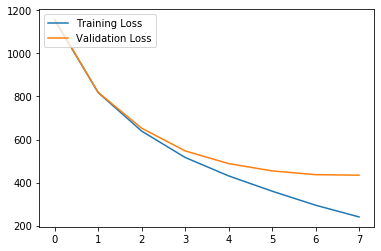

In [35]:
# You can tune these hyperparameters as you like.
epoch = 8
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(reduced_trainset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=4)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
model = CNNClassifier(n_input, n_classes)
model.to(device)

optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

loss_hist_train = []
loss_hist_val = []
val_loader_iterator = iter(val_loader)
    
for e in range(epoch):
    loss_epoch = 0
    loss_val_epoch = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = y_pred.to(device)
        y_pred = model(x)
        
        loss = cross_entropy(y_pred, y)
        
        # This section is just to test against validation set. We don't need to keep track of gradients here.
        with torch.no_grad():
            try:
                x_val, y_val = next(val_loader_iterator)
            except StopIteration:
                # Validation set is smaller than training set so we'll run out of batches faster, reinstantiate
                # if we do.
                val_loader_iterator = iter(val_loader)
                x_val, y_val = next(val_loader_iterator)
                
            # Just make a prediction with the validation x and y and get the loss
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_val_pred = model(x_val)
            loss_val = cross_entropy(y_val_pred, y_val)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_epoch += loss.item()
        loss_val_epoch += loss_val.item()

    loss_hist_val.append(loss_val_epoch)
    loss_hist_train.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist_train)
plt.plot(loss_hist_val)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [36]:
# turn on evaluation mode. This is crucial when you have BatchNorm in your network,
# as you want to use the running mean/std you obtain durining training time to normalize
# your input data. Rememeber to call .train() function after evaluation

# Get the testing accuracy and plot for each number of layers:
test_acc_depth = [0] * 3

model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

# For plot later
test_acc_depth[1] = test_acc

tensor(36866, device='cuda:0')
tensor(7853, device='cuda:0')
Training accuracy: 92.16500091552734, Testing accuracy: 78.52999877929688


<span style="color:red">**Explain your design and hyperparameter choice in three or four sentences:**</span>

<strong>Answer:</strong>

I already played with several different number of layers/padding/kernel size/depth at this point, before realizing the rest of the assignment IS to try these parameters out. So, thank you for letting us try out all these different configurations, it's really interesting. 

At this point in the submission I'll just use this architecture, then refine it in the next sections. Currently I have 4 layers of Conv2d followed by pooling after each conv layer. Tried using smaller kernels but more output channels to extract more features early on, maybe if we increase the layers even more that might increase accuracy. Added padding so corner of the images also gets some weight. I follow that with 3 fc layers. Also split the training set into validation set (20%) and training set (80%) then plotted it out so it's easier to do hyperparameter tuning. Using momentum SGD with 0.8 momentum.



### 2.2.2 STACK MORE LAYERS [10 pts]
Now, **try at least 4 network architectures with different numbers of convolutional layers**. Train these settings with `optim.SGD`, plot the accuracy as a fuction of convolutional layers and describe what you have observed (running time, performance, etc). 

In [37]:
# For 6 layer conv network, I also tried adding dropout regularization because as you can see from the
# previous 4 layer CNN, after epoch 5 validation error goes up while training error goes down - we're overfitting. 
# After we plot the 2 layer CNN, we'll try adding some other regularization, and maybe some batch norm layers.
class CNNClassifier_6(nn.Module):
    
    def __init__(self, n_input, n_classes):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
        hidden_layer_size = 64
        
        # In channels = 3 because of RGB, 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        
        self.fc1 = nn.Linear(256 * 4 * 4, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, n_classes)    
    
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
#         import pdb; pdb.set_trace()
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.pool4(self.relu(self.conv4(x)))
        x = self.pool5(self.relu(self.conv5(x)))
        x = self.pool6(self.relu(self.conv6(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.dropout(self.fc3(x))
        return x
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

Epcoh 0: 1251.838905453682
Epcoh 1: 1009.454139828682
Epcoh 2: 861.4083225727081
Epcoh 3: 752.16428399086
Epcoh 4: 675.5119631290436
Epcoh 5: 603.798300921917
Epcoh 6: 552.9130141735077
Epcoh 7: 502.6481205224991


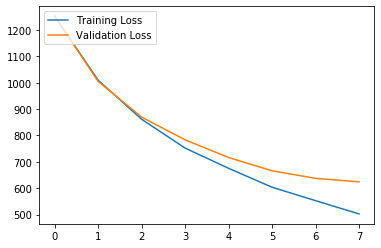

In [38]:
# Run 6 layer CNN
epoch = 8
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(reduced_trainset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=4)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
model6 = CNNClassifier_6(n_input, n_classes)
model6.to(device)

# Initialize weights with Kaiming, just curious to try. It's not very deep so shouldn't have impact.:
def init_weights_kaiming(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        
model6.apply(init_weights_kaiming)

optim = torch.optim.SGD(model6.parameters(), lr=lr, momentum=0.8)
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

loss_hist_train = []
loss_hist_val = []
val_loader_iterator = iter(val_loader)
    
for e in range(epoch):
    loss_epoch = 0
    loss_val_epoch = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model6(x)
        
        loss = cross_entropy(y_pred, y)
        
        # This section is just to test against validation set. We don't need to keep track of gradients here.
        with torch.no_grad():
            try:
                x_val, y_val = next(val_loader_iterator)
            except StopIteration:
                # Validation set is smaller than training set so we'll run out of batches faster, reinstantiate
                # if we do.
                val_loader_iterator = iter(val_loader)
                x_val, y_val = next(val_loader_iterator)
                
            # Just make a prediction with the validation x and y and get the loss
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_val_pred = model6(x_val)
            loss_val = cross_entropy(y_val_pred, y_val)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_epoch += loss.item()
        loss_val_epoch += loss_val.item()

    loss_hist_val.append(loss_val_epoch)
    loss_hist_train.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist_train)
plt.plot(loss_hist_val)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [39]:
# Evaluate 6 layer CNN
model6.eval()
train_acc = get_model_acc(model6, train_loader)
test_acc = get_model_acc(model6, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
# For plot later
test_acc_depth[2] = test_acc

tensor(34535, device='cuda:0')
tensor(7723, device='cuda:0')
Training accuracy: 86.33749389648438, Testing accuracy: 77.2300033569336


In [40]:
# Just do a 2 layer network for the simple plot with relation to depth of CNN layers.
class CNNClassifier_2(nn.Module):
    
    def __init__(self, n_input, n_classes):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
        hidden_layer_size = 64
        
        # In channels = 3 because of RGB, 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
           
        self.fc1 = nn.Linear(128 * 8 * 8, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, n_classes)    
    
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
#         import pdb; pdb.set_trace()
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.dropout(self.fc3(x))
        return x
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

Epcoh 0: 1159.6992956399918
Epcoh 1: 950.8789750337601
Epcoh 2: 842.7469898462296
Epcoh 3: 765.0110471248627
Epcoh 4: 716.0283551216125
Epcoh 5: 671.5659872293472
Epcoh 6: 629.8970526456833
Epcoh 7: 587.5829052329063


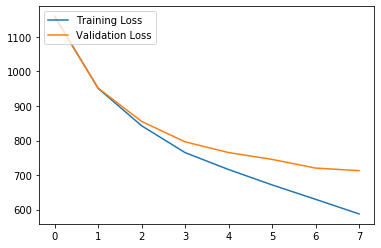

In [41]:
# Run 2 layer CNN
epoch = 8
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(reduced_trainset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=4)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
model2 = CNNClassifier_2(n_input, n_classes)
model2.to(device)

optim = torch.optim.SGD(model2.parameters(), lr=lr, momentum=0.8)
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

loss_hist_train = []
loss_hist_val = []
val_loader_iterator = iter(val_loader)
    
for e in range(epoch):
    loss_epoch = 0
    loss_val_epoch = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model2(x)
        
        loss = cross_entropy(y_pred, y)
        
        # This section is just to test against validation set. We don't need to keep track of gradients here.
        with torch.no_grad():
            try:
                x_val, y_val = next(val_loader_iterator)
            except StopIteration:
                # Validation set is smaller than training set so we'll run out of batches faster, reinstantiate
                # if we do.
                val_loader_iterator = iter(val_loader)
                x_val, y_val = next(val_loader_iterator)
                
            # Just make a prediction with the validation x and y and get the loss
            y_val = y_val.to(device)
            x_val = x_val.to(device)
            y_val_pred = model2(x_val)
            loss_val = cross_entropy(y_val_pred, y_val)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_epoch += loss.item()
        loss_val_epoch += loss_val.item()

    loss_hist_val.append(loss_val_epoch)
    loss_hist_train.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist_train)
plt.plot(loss_hist_val)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [42]:
# Evaluate 2 layer CNN (2 conv layers)
model2.eval()
train_acc = get_model_acc(model2, train_loader)
test_acc = get_model_acc(model2, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
# For plot later
test_acc_depth[0] = test_acc

tensor(32818, device='cuda:0')
tensor(7250, device='cuda:0')
Training accuracy: 82.04499816894531, Testing accuracy: 72.5


In [43]:
# Trying to optimize with batch norm in the 6 layer network.

class CNNClassifier_6_batchnorm(nn.Module):
    
    def __init__(self, n_input, n_classes):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
        hidden_layer_size = 512
        
        # In channels = 3 because of RGB, 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn5   = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6   = nn.BatchNorm2d(256)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        
        self.fc1 = nn.Linear(256 * 4 * 4, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, n_classes)    
    
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
#         import pdb; pdb.set_trace()
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu(self.bn5(self.conv5(x))))
        x = self.pool6(self.relu(self.bn6(self.conv6(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.dropout(self.fc3(x))
        return x
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

Epcoh 0: 1068.0862720012665
Epcoh 1: 806.5610074400902
Epcoh 2: 680.7949711680412
Epcoh 3: 596.956195294857
Epcoh 4: 528.7516746520996
Epcoh 5: 482.4986637532711
Epcoh 6: 440.9442280828953
Epcoh 7: 406.6629312336445
Epcoh 8: 371.4560295045376
Epcoh 9: 346.537205517292
Epcoh 10: 315.59139470756054
Epcoh 11: 295.54320515692234


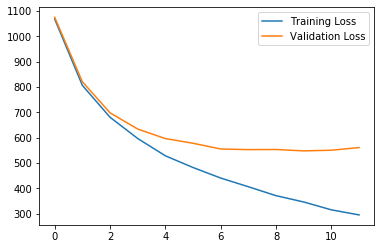

In [44]:
# Run 6 layer CNN
epoch = 12
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(reduced_trainset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=4)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
model6n = CNNClassifier_6_batchnorm(n_input, n_classes)
model6n.to(device)

# Initialize weights with Kaiming, just curious to try. It's not very deep so shouldn't have impact.:
def init_weights_kaiming(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        
model6n.apply(init_weights_kaiming)

optim = torch.optim.SGD(model6n.parameters(), lr=lr, momentum=0.8)
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

loss_hist_train = []
loss_hist_val = []
val_loader_iterator = iter(val_loader)
    
for e in range(epoch):
    loss_epoch = 0
    loss_val_epoch = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model6n(x)
        
        loss = cross_entropy(y_pred, y)
        
        # This section is just to test against validation set. We don't need to keep track of gradients here.
        with torch.no_grad():
            try:
                x_val, y_val = next(val_loader_iterator)
            except StopIteration:
                # Validation set is smaller than training set so we'll run out of batches faster, reinstantiate
                # if we do.
                val_loader_iterator = iter(val_loader)
                x_val, y_val = next(val_loader_iterator)
                
            # Just make a prediction with the validation x and y and get the loss
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_val_pred = model6n(x_val)
            loss_val = cross_entropy(y_val_pred, y_val)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_epoch += loss.item()
        loss_val_epoch += loss_val.item()

    loss_hist_val.append(loss_val_epoch)
    loss_hist_train.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist_train)
plt.plot(loss_hist_val)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [45]:
# Evaluate 6 layer modified CNN, this is the one with batch Norm
model6n.eval()
train_acc = get_model_acc(model6n, train_loader)
test_acc = get_model_acc(model6n, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(36041, device='cuda:0')
tensor(7794, device='cuda:0')
Training accuracy: 90.10250091552734, Testing accuracy: 77.94000244140625


In [13]:
# What if we follow known architectures and stack a few Conv layers before we actually do any max pooling? 
# Add on to the architecture that already has batch norm and dropout with 6 conv layers.

# WARNING: THIS MODEL TOOK THE WHOLE NIGHT TO RUN WHEN TRYING TO RUN WITH CPU, CUDA RUNS OUT OF MEMORY

class CNNClassifier_6_modified(nn.Module):
    
    def __init__(self, n_input, n_classes):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
        hidden_layer_size = 256
        
        # In channels = 3 because of RGB, 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
               
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
              
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
            
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn5   = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6   = nn.BatchNorm2d(256)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, n_classes)    
    
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
#         import pdb; pdb.set_trace()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(self.relu(self.bn3(self.conv3(x))))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool2(self.relu(self.bn6(self.conv6(x))))
        x = x.view(-1, 256 * 8 * 8)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.dropout(self.fc3(x))
        return x
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [14]:
# Run modified 6 layer CNN. WARNING, takes a few hours to run.
torch.cuda.empty_cache()
epoch = 12
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(reduced_trainset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=4)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
model6m = CNNClassifier_6_modified(n_input, n_classes)
model6m.to(device)

# Initialize weights with Kaiming, just curious to try. It's not very deep so shouldn't have impact.:
def init_weights_kaiming(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        
model6m.apply(init_weights_kaiming)

optim = torch.optim.SGD(model6m.parameters(), lr=lr, momentum=0.8)
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

loss_hist_train = []
loss_hist_val = []
val_loader_iterator = iter(val_loader)
    
for e in range(epoch):
    loss_epoch = 0
    loss_val_epoch = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model6m(x)
        
        loss = cross_entropy(y_pred, y)
        
        # This section is just to test against validation set. We don't need to keep track of gradients here.
        with torch.no_grad():
            try:
                x_val, y_val = next(val_loader_iterator)
            except StopIteration:
                # Validation set is smaller than training set so we'll run out of batches faster, reinstantiate
                # if we do.
                val_loader_iterator = iter(val_loader)
                x_val, y_val = next(val_loader_iterator)
                
            # Just make a prediction with the validation x and y and get the loss
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_val_pred = model6m(x_val)
            loss_val = cross_entropy(y_val_pred, y_val)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_epoch += loss.item()
        loss_val_epoch += loss_val.item()

    loss_hist_val.append(loss_val_epoch)
    loss_hist_train.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist_train)
plt.plot(loss_hist_val)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 1.96 GiB total capacity; 711.44 MiB already allocated; 15.12 MiB free; 86.56 MiB cached)

In [ ]:
# Evaluate 6 layer modified CNN, with fewer pooling layers
model6m.eval()
train_acc = get_model_acc(model6m, train_loader)
test_acc = get_model_acc(model6m, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

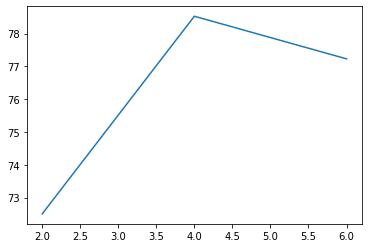

In [47]:
# Ok, let's plot the test accuracy over the depth of the neural network 
plt.plot([2,4,6],test_acc_depth)

<span style="color:red">**Briefly explain what you have observed in three or four sentences. Does stacking layers always give you better results? How about the computational time?:**</span>

<strong>Answer:</strong>
Stacking layers makes it take longer to train. After a certain point it doesn't necessarily give better results until we perform batch norm on the network. I also noticed that when using fewer pooling layers (2 as opposed to 6) it takes even longer to train. Currently with 6 conv layers, batch norm and dropout we're getting around 81% accuracy.

### 2.2.3 Optimizer? Optimizer! [10 pts]
So far, we only use SGD as our optimizer. Now, pick two other optimizers, train your CNN models, and compare the performance you get. What did you see?

Epcoh 0: 1008.6534453630447
Epcoh 1: 736.4605672359467
Epcoh 2: 617.3161231279373
Epcoh 3: 539.9106099009514
Epcoh 4: 479.1007621884346
Epcoh 5: 424.50288850069046
Epcoh 6: 374.3410021662712
Epcoh 7: 326.8515087366104


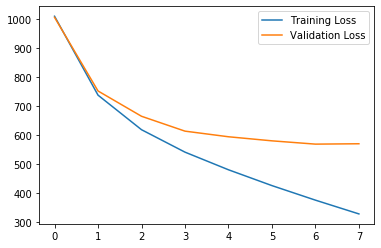

In [62]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################

# Reuse our batch-normed 6 layer CNN class. Try different optimizers. First let's try Adagrad
torch.cuda.empty_cache()
epoch = 8
lr = 1e-3
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(reduced_trainset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=4)

model6_adagrad = CNNClassifier_6_batchnorm(n_input, n_classes)
model6_adagrad.to(device)

# Initialize weights with Kaiming, just curious to try. It's not very deep so shouldn't have impact.:
def init_weights_kaiming(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        
model6_adagrad.apply(init_weights_kaiming)

optim = torch.optim.Adagrad(model6_adagrad.parameters(), lr=lr, weight_decay=0.1)
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

loss_hist_train = []
loss_hist_val = []
val_loader_iterator = iter(val_loader)
    
for e in range(epoch):
    loss_epoch = 0
    loss_val_epoch = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = y_pred.to(device)
        y_pred = model6_adagrad(x)
        
        loss = cross_entropy(y_pred, y)
        
        # This section is just to test against validation set. We don't need to keep track of gradients here.
        with torch.no_grad():
            try:
                x_val, y_val = next(val_loader_iterator)
            except StopIteration:
                # Validation set is smaller than training set so we'll run out of batches faster, reinstantiate
                # if we do.
                val_loader_iterator = iter(val_loader)
                x_val, y_val = next(val_loader_iterator)
                
            # Just make a prediction with the validation x and y and get the loss
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_val_pred = model6_adagrad(x_val)
            loss_val = cross_entropy(y_val_pred, y_val)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_epoch += loss.item()
        loss_val_epoch += loss_val.item()

    loss_hist_val.append(loss_val_epoch)
    loss_hist_train.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist_train)
plt.plot(loss_hist_val)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [63]:
# Evaluate Adagrad
model6_adagrad.eval()
train_acc = get_model_acc(model6_adagrad, train_loader)
test_acc = get_model_acc(model6_adagrad, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(35438, device='cuda:0')
tensor(7460, device='cuda:0')
Training accuracy: 88.5949935913086, Testing accuracy: 74.5999984741211


Epcoh 0: 1087.7977675199509
Epcoh 1: 799.6458924412727
Epcoh 2: 671.1942526698112
Epcoh 3: 590.1090431213379
Epcoh 4: 532.9777426123619
Epcoh 5: 474.87821385264397
Epcoh 6: 439.16869965195656
Epcoh 7: 404.88590720295906
Epcoh 8: 374.1950960755348
Epcoh 9: 337.909188836813


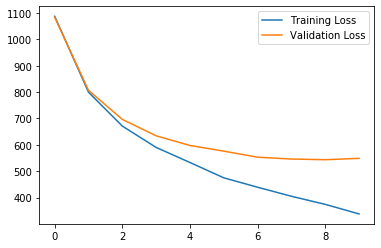

In [64]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################

# Reuse our modified 6 layer CNN class. Try different optimizers. Next, let's try nesterov momentum!

epoch = 10
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(reduced_trainset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=4)

model6_nesterov = CNNClassifier_6_batchnorm(n_input, n_classes)
model6_nesterov.to(device)

# Initialize weights with Kaiming, just curious to try. It's not very deep so shouldn't have impact.:
def init_weights_kaiming(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        
model6_nesterov.apply(init_weights_kaiming)

optim = torch.optim.SGD(model6_nesterov.parameters(), lr=lr, momentum=0.8, nesterov=True)
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

loss_hist_train = []
loss_hist_val = []
val_loader_iterator = iter(val_loader)
    
for e in range(epoch):
    loss_epoch = 0
    loss_val_epoch = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = y_pred.to(device)
        y_pred = model6_nesterov(x)
        
        loss = cross_entropy(y_pred, y)
        
        # This section is just to test against validation set. We don't need to keep track of gradients here.
        with torch.no_grad():
            try:
                x_val, y_val = next(val_loader_iterator)
            except StopIteration:
                # Validation set is smaller than training set so we'll run out of batches faster, reinstantiate
                # if we do.
                val_loader_iterator = iter(val_loader)
                x_val, y_val = next(val_loader_iterator)
                
            # Just make a prediction with the validation x and y and get the loss
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_val_pred = model6_nesterov(x_val)
            loss_val = cross_entropy(y_val_pred, y_val)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_epoch += loss.item()
        loss_val_epoch += loss_val.item()

    loss_hist_val.append(loss_val_epoch)
    loss_hist_train.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist_train)
plt.plot(loss_hist_val)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [65]:
# Evaluate nesterov momentum
model6_nesterov.eval()
train_acc = get_model_acc(model6_nesterov, train_loader)
test_acc = get_model_acc(model6_nesterov, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(35634, device='cuda:0')
tensor(7865, device='cuda:0')
Training accuracy: 89.08499145507812, Testing accuracy: 78.64999389648438


<span style="color:red">**What did you see? Which optimizer is your favorite? Describe:**</span>

<strong>Answer:</strong>
I tried SGD with nesterov momentum and Adagrad. Adagrad requires a lower learning rate of 1e-3 than SGD with momentum which decreases very fast with a relatively high learning rate of 1e-2.

### 2.2.4 Improve Your Model [10 pts]
Again, we want you to play with your model a bit harder, and improve it. You are free to use everything you can find in the documents (`BatchNorm`, `SeLU`, etc), as long as it is not a **predefined network architectures in PyTorch package**. You can also implement some famous network architectures to push the performance. 

(A simple network with 5-6 `nn.Conv2d` can give you at least 70% accuracy on testing set).

In [69]:
# I wanted to try Alexnet or VGG16, then realized it takes days to train...let's just reuse and tweak our
# previous 6 layer conv net.

class CNNClassifier_6_final(nn.Module):
    
    def __init__(self, n_input, n_classes):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
        hidden_layer_size = 1024
        
        # In channels = 3 because of RGB, let's try similar to VGG and Alex where we use fewer filters first.
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)
            
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5   = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn6   = nn.BatchNorm2d(512)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=1)    
        
        self.fc1 = nn.Linear(512 * 2 * 2, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size//2)
        self.fc3 = nn.Linear(hidden_layer_size//2, n_classes)    
    
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
#         import pdb; pdb.set_trace()
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu(self.bn5(self.conv5(x))))
        x = self.pool6(self.relu(self.bn6(self.conv6(x))))
        
        x = x.view(-1, 512 * 2 * 2)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.dropout(self.fc3(x))
        return x
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

Epcoh 0: 1069.9016573429108
Epcoh 1: 781.510619521141
Epcoh 2: 657.6503812074661
Epcoh 3: 579.0636982321739
Epcoh 4: 521.2483074963093
Epcoh 5: 477.79036316275597
Epcoh 6: 440.99518167972565
Epcoh 7: 406.2475917041302
Epcoh 8: 375.75778406858444
Epcoh 9: 345.38573828339577


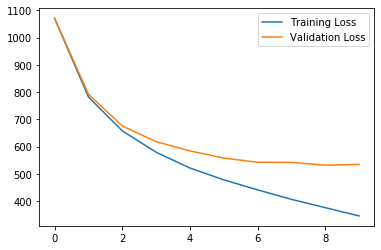

In [76]:
# Run our finalized 6 layer CNN. Might take a long time to run.

epoch = 10
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(reduced_trainset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=4)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
model6f = CNNClassifier_6_final(n_input, n_classes)
model6f.cuda()

# Initialize weights with Kaiming, just curious to try. It's not very deep so shouldn't have impact.:
def init_weights_kaiming(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        
model6f.apply(init_weights_kaiming)

optim = torch.optim.SGD(model6f.parameters(), lr=lr, momentum=0.8, nesterov=True)
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

loss_hist_train = []
loss_hist_val = []
val_loader_iterator = iter(val_loader)
    
for e in range(epoch):
    loss_epoch = 0
    loss_val_epoch = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = y_pred.to(device)

        y_pred = model6f(x)
        
        loss = cross_entropy(y_pred, y)
        
        # This section is just to test against validation set. We don't need to keep track of gradients here.
        with torch.no_grad():
            try:
                x_val, y_val = next(val_loader_iterator)
            except StopIteration:
                # Validation set is smaller than training set so we'll run out of batches faster, reinstantiate
                # if we do.
                val_loader_iterator = iter(val_loader)
                x_val, y_val = next(val_loader_iterator)
                
            # Just make a prediction with the validation x and y and get the loss
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_val_pred = model6f(x_val)
            loss_val = cross_entropy(y_val_pred, y_val)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_epoch += loss.item()
        loss_val_epoch += loss_val.item()

    loss_hist_val.append(loss_val_epoch)
    loss_hist_train.append(loss_epoch)
    print(f'Epcoh {e}: {loss_epoch}')

plt.plot(loss_hist_train)
plt.plot(loss_hist_val)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [77]:
# Evaluate final
model6f.eval()
train_acc = get_model_acc(model6f, train_loader)
test_acc = get_model_acc(model6f, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(36690, device='cuda:0')
tensor(8064, device='cuda:0')
Training accuracy: 91.7249984741211, Testing accuracy: 80.63999938964844
